In [1]:
kaggle=1
collab=0

In [2]:

if kaggle:
    import os
    os.listdir("/kaggle/input/go-go-nihongo")
    # !cd /kaggle/input/go-go-nihongo
    # print(os.getcwd())
    %cd /kaggle/input/go-go-nihongo
    print(os.getcwd())

/kaggle/input/go-go-nihongo
/kaggle/input/go-go-nihongo


In [3]:
if collab:
  from google.colab import drive
  drive.mount('/content/drive')

  %cd /content/drive/MyDrive/Projects/GO_GO_Nihongo

In [4]:
from IPython.display import clear_output
%pip install janome mojimoji
!pip install sentencepiece
!pip install nltk
!pip install scikit-learn
!pip install matplotlib
clear_output()

In [5]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, dot, Activation, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras import initializers, regularizers, constraints

from sklearn.model_selection import train_test_split


import mojimoji
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import io

import nltk
import unicodedata
import sentencepiece as spm

# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(tf.__version__)
# gpu
tf.test.is_gpu_available()

2.16.1


True

# load text file

this dataset is aleady implemented a SentenceSpace

In [6]:
from janome.tokenizer import Tokenizer
import mojimoji

# Initialize Japanese tokenizer
tokenizer = Tokenizer()


def preprocess_japanese_text(text):
    # Convert full-width characters to half-width
    text = mojimoji.zen_to_han(text)

    # Tokenize the text
    tokens = tokenizer.tokenize(text, wakati=True)

    # Join tokens with a space to preserve word boundaries for translation models
    preprocessed_text = " ".join(tokens)

    # Remove any unnecessary whitespace
    preprocessed_text = preprocessed_text.strip()

    return preprocessed_text


# Example usage
text = "今日は今日はとても良い日です。"
processed_text = preprocess_japanese_text(text)
print(processed_text)

今日 は 今日 は とても 良い 日 です ｡


In [7]:
import pandas as pd

df = pd.read_csv("./datas/Aniki.csv",index_col=False)
# first_run Uncomment the below line for the 1st run
# df=df[:1000] 
df

,Unnamed: 0,english,japanese,_eng_len,_jpn_len
0,0,go.,行け 。,1,2
1,1,go.,行き なさい 。,1,3
2,2,hi.,こんにちは 。,1,2
3,3,hi.,もしもし 。,1,2
4,4,hi.,やっ ほ ー 。,1,4
...,...,...,...,...,...
109774,109774,the small crowd at hiroshima peace memorial pa...,アメリカ 軍用 機 エノラ・ゲイ から 「 リトル ボーイ 」 と 名付け られ た 原子 ...,34,44
109775,109775,"""i heard that tom and john are identical twins...",「 トム と ジョン って 一卵性双生児 と は 聞い て た けど 、 本当に よく 似 ...,41,50
109776,109776,"when i was younger, i hated going to weddings....",若い 頃 って さぁ 、 結婚式 に 行く の が 嫌 で 嫌 で たまらなかっ た わ 。...,44,86
109777,109777,if someone who does not know your background s...,生い立ち を 知ら ない 人 に ネイティブ みたい に 聞こえる よ って 言わ れ たら...,47,58


In [8]:
import re
import pandas as pd
import tqdm


emoji_list_datas_path = "./datas//Emoji Sheets - Emoji Only.csv"
emoji_df = pd.read_csv(emoji_list_datas_path)

# Extract the emojis into a list
emoji_list = emoji_df["Emoji_List"].tolist()

# Start the pattern string
pattern = "["

# Append each code point to the pattern string, ensuring each one is 8 digits
for cp in emoji_list:
    pattern += f"\\U{cp[1:]:0>8}"

# Close the pattern string
pattern += "]"

# Compile the regular expression
emoji_pattern = re.compile(pattern, re.UNICODE)


# function to completely remove the emojis from the comments using re
def remove_emojis(text):
    if not isinstance(text, str):
        return text  # or return an empty string: return ''

    # Compile the regular expression
    emoji_pattern = re.compile(pattern, re.UNICODE)

    # Use the sub method to remove emojis
    text_no_emojis = emoji_pattern.sub(r"", text)
    return text_no_emojis

In [9]:
from tqdm import tqdm

tqdm.pandas(desc="Removing emojis from English text")
df["english"] = df["english"].progress_apply(remove_emojis)

tqdm.pandas(desc="Removing emojis from Japanese text")
df["japanese"] = df["japanese"].progress_apply(remove_emojis)

Removing emojis from Japanese text: 100%|██████████| 109779/109779 [00:04<00:00, 24747.09it/s]


In [10]:
import mojimoji


def zen_to_han(text):
    return mojimoji.zen_to_han(text)

In [11]:
import unicodedata


# English might have accent like é but Japanese doesn't have any accent I just create different function to ascii for Japanese and English
# Removing accented characters
def english_unicode_to_ascii(text):
    return "".join(
        ascii_text
        for ascii_text in unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )


def japanese_unicode_to_ascii(text):
    return " ".join(ascii_text for ascii_text in unicodedata.normalize("NFKD", text))


japanese_unicode_to_ascii("こんにちは。 今日は"), english_unicode_to_ascii(
    "Hello world é "
)

('こ ん に ち は 。   今 日 は', 'Hello world e ')

In [12]:
import re


def clean_text(text):
    # Define regex pattern for allowed characters (Latin letters and Japanese characters)
    allowed_pattern = r"[^a-zA-Z\u4E00-\u9FFF\u3040-\u30FF\s]"
    # Replace everything not in allowed pattern with a space
    cleaned_text = re.sub(allowed_pattern, " ", text)

    # Remove extra spaces
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    cleaned_text = cleaned_text.lower()

    return cleaned_text


# Example usage
text = "こんにちは、世界! This is an example sentence."
print(clean_text(text))

こんにちは 世界 this is an example sentence


In [13]:
%pip install janome mojimoji
from janome.tokenizer import Tokenizer
import mojimoji

# Initialize Japanese tokenizer
tokenizer = Tokenizer()


def preprocess_japanese_text(text):

    # TODO: Uncomment the line below to convert Japanese text to ASCII characters PROBLEM: cause the problem in tokenization
    # text=japanese_unicode_to_ascii(text)

    # Convert full-width characters to half-width
    text = mojimoji.zen_to_han(text)

    text = clean_text(text)

    # Tokenize the text
    tokens = tokenizer.tokenize(text, wakati=True)

    # Join tokens with a space to preserve word boundaries for translation models
    preprocessed_text = " ".join(tokens)

    # Remove any unnecessary whitespace
    preprocessed_text = preprocessed_text.strip()

    return "start_ " + preprocessed_text + " _end"


text = "猫と犬がけんかしている。"
processed_text = preprocess_japanese_text(text)
print(processed_text)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.
start_ 猫 と 犬 が けんか し て いる _end


In [14]:
# from transformers import BertTokenizer

# def preprocess_english_text(text):
#     # Initialize the tokenizer
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#     # Normalize text
#     text = text.lower()

#     text=english_unicode_to_ascii(text)

#     text=clean_text(text)

#     # Tokenize text
#     tokens = tokenizer.tokenize(text)

#     # Join tokens with a space to preserve word boundaries for translation models
#     preprocessed_text = " ".join(tokens)

#     # Remove any unnecessary whitespace
#     preprocessed_text = preprocessed_text.strip()

#     return "start_ " + preprocessed_text + " _end"

#     # # Convert tokens to token IDs
#     # token_ids = tokenizer.convert_tokens_to_ids(tokens)

#     # # Add special tokens
#     # token_ids = tokenizer.build_inputs_with_special_tokens(token_ids)

#     # # Create attention mask
#     # attention_mask = [1] * len(token_ids)

#     # return token_ids, attention_mask

from tensorflow.keras.preprocessing.text import Tokenizer
def preprocess_english_text(text):

    # Normalize text (you need to define these functions)
    text = text.lower()  # Convert text to lowercase
    text = english_unicode_to_ascii(text)  # Placeholder for your normalization
    text = clean_text(text)  # Placeholder for your cleaning function

    # Add special tokens
    preprocessed_text = f"start_ {text} _end"

    return preprocessed_text

# Example usage
text = "Hello, how are you?"
token = preprocess_english_text(text)
token

'start_ hello how are you _end'

In [15]:
from tqdm  import tqdm


tqdm.pandas(desc="Preprocessing English text")
df["english_preprocessed"] = df["english"].progress_apply(preprocess_english_text)


tqdm.pandas(desc="Preprocessing Japanese text")
df["japanese_preprocessed"] = df["japanese"].progress_apply(preprocess_japanese_text)

# df.to_csv("./datas/eng_jap_dataset_preprocessed.csv")

Preprocessing Japanese text: 100%|██████████| 109779/109779 [01:08<00:00, 1614.00it/s]


# tokenize
tokenize each language word based on space

In [16]:
def tokenize(lang):
    # vectorize a text corpus
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters=' ')

    # updates internal vocabulary based on a list of texts
    # e.g. "[this place is good ]"→{this:2, place:3, is:1, good:4} "
    lang_tokenizer.fit_on_texts(lang)

    # Transforms each text in texts to a sequence of integers.
    # e.g. this place is good → [[2, 3, 1, 4]]
    tensor = lang_tokenizer.texts_to_sequences(lang)

    # transform a list of num sample into a 2D Numpy array of shape
    # Fixed length because length of sequence of integers are different
    # return (len(sequences), maxlen)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post')
    return tensor, lang_tokenizer

In [17]:
# e.g.
tokenize(['this place is good', "こんにちは 今日は いい天気 。", "today is so cold"])

(array([[ 2,  3,  1,  4],
        [ 5,  6,  7,  8],
        [ 9,  1, 10, 11]], dtype=int32),
 <keras.src.legacy.preprocessing.text.Tokenizer at 0x7b5b8ba7cd60>)

# create clean dataset

In [18]:
# cleate a clean dataset
def create_dataset( ja,en):

    # input_tensor, target_tensor: 2d numpy array
    # input_lang_tokenize, target_lang_tokenize: word dictionary
    input_tensor, input_lang_tokenize = tokenize(ja)
    target_tensor, target_lang_tokenize = tokenize(en)

    return input_tensor, target_tensor, input_lang_tokenize, target_lang_tokenize

In [19]:
input_tensor, target_tensor, input_lang_tokenize, target_lang_tokenize = create_dataset(df["japanese_preprocessed"],df["english_preprocessed"])
(len(input_tensor), len(target_tensor))

(109779, 109779)

In [20]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

input_tokenizer_saving_path="/kaggle/working/input_tokenizer.json" if kaggle else "./input_tokenizer.json"
target_tokenizer_saving_path="/kaggle/working/target_tokenizer.json" if kaggle else "./target_tokenizer.json"

# Save the tokenizer to a .pkl file
with open(input_tokenizer_saving_path, 'wb') as file:
    pickle.dump(input_lang_tokenize, file)

with open(target_tokenizer_saving_path, 'wb') as file:
    pickle.dump(target_lang_tokenize, file)
    
print("Tokenizer saved as tokenizer.pkl")

# Later, load the tokenizer back
with open(input_tokenizer_saving_path, 'rb') as file:
    input_lang_tokenize_test = pickle.load(file)

with open(target_tokenizer_saving_path, 'rb') as file:
    target_lang_tokenize_test = pickle.load(file)
print("Tokenizer loaded successfully")
# print(input_lang_tokenize_test.word_index) 
# print(input_lang_tokenize_test.word_index) 

Tokenizer saved as tokenizer.pkl
Tokenizer loaded successfully


In [21]:
preprocessed_input_jap = preprocess_japanese_text("こんにちは 今日は いい天気 。")  # Adjust for your input language
preprocessed_input_eng = preprocess_english_text("today is so cold")  
input_sequence_jap = input_lang_tokenize.texts_to_sequences([preprocessed_input_jap])
input_sequence_eng = target_lang_tokenize.texts_to_sequences([preprocessed_input_eng])
(input_sequence_jap, input_sequence_eng)

([[1, 2360, 75, 3, 39, 295, 2]], [[1, 90, 7, 74, 163, 2]])

In [22]:
preprocessed_input_jap = preprocess_japanese_text("こんにちは 今日は いい天気 。")  # Adjust for your input language
preprocessed_input_eng = preprocess_english_text("today is so cold")  
input_sequence_jap = input_lang_tokenize_test.texts_to_sequences([preprocessed_input_jap])
input_sequence_eng = target_lang_tokenize_test.texts_to_sequences([preprocessed_input_eng])
(input_sequence_jap, input_sequence_eng)

([[1, 2360, 75, 3, 39, 295, 2]], [[1, 90, 7, 74, 163, 2]])

In [23]:
def max_length(input_tensor, target_tensor):

    # max length of input sentense and target sentense
    english_len = [len(i) for i in target_tensor ]

    japanese_len = [len(i) for i in input_tensor]

     # print max length
    print("english length:", max(english_len))
    print("japanese length:", max(japanese_len))

    max_len_input=  max(japanese_len)
    max_len_target =  max(english_len)

    return max_len_input, max_len_target

In [24]:
# Calculate max_length of the target tensors
max_length_input, max_length_target = max_length(input_tensor, target_tensor)
(max_length_input, max_length_target)

english length: 61
japanese length: 73


(73, 61)

In [25]:
# create trainnig set and validation set
X_train, X_test, \
    Y_train, Y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, shuffle=True)

X_test, X_val, \
    Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, shuffle=True)


# show length
print(len(X_train), len(Y_train), len(X_test), len(Y_test), len(X_val), len(Y_val))

87823 87823 10978 10978 10978 10978


In [26]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            # Index number assigned to each word
            print("%d----->%s" % (t, lang.index_word[t]))

In [27]:
print("input lang: index to word mapping")
convert(input_lang_tokenize, X_train[10])
print("output lang: index to word mapping")
convert(target_lang_tokenize, Y_train[10])

input lang: index to word mapping
1----->start_
55----->これ
3----->は
478----->かなり
4967----->衝撃
48----->だっ
4----->た
13----->よ
2----->_end
output lang: index to word mapping
1----->start_
3----->i
18----->was
446----->quite
2468----->shocked
62----->by
21----->this
2----->_end


# define parameter

In [28]:
# config_B64_D0.3_E300_U512
# first_run ensure that the value printed below is never 0
import tensorflow as tf

# Configuration details
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
dropout_rate = 0.3
embedding_dim = 300
units = 512

# Calculating steps per epoch
train_steps_per_epoch = len(X_train) // BATCH_SIZE
val_steps_per_epoch = len(X_val) // BATCH_SIZE

print(f"Train steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")

# Vocabulary sizes
vocab_inp_size = len(input_lang_tokenize.word_index) + 1
vocab_tar_size = len(target_lang_tokenize.word_index) + 1

print(f"Total unique words in the input: {len(input_lang_tokenize.word_index)}")
print(f"Total unique words in the target: {len(target_lang_tokenize.word_index)}")
print(f"Vocabulary input size: {vocab_inp_size}")
print(f"Vocabulary target size: {vocab_tar_size}")

# Create train and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(BATCH_SIZE, drop_remainder=True)

print(f"File_name: config_B{BATCH_SIZE}_D{dropout_rate}_E{embedding_dim}_U{units}")

Train steps per epoch: 1372
Validation steps per epoch: 171
Total unique words in the input: 15619
Total unique words in the target: 11382
Vocabulary input size: 15620
Vocabulary target size: 11383
File_name: config_B64_D0.3_E300_U512


# Encoder Model

In [29]:
# from tensorflow.keras.saving import register_keras_serializable

# @register_keras_serializable()
# class Encoder(tf.keras.Model):
#     def __init__(self, vocab_size, embedding_dim, enc_units, batch_size, dropout_rate):
#         super(Encoder, self).__init__()
#         self.batch_size = batch_size
#         self.enc_units = enc_units
#         self.dropout = Dropout(dropout_rate)
#         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.first_lstm = tf.keras.layers.LSTM(self.enc_units,
#                                                             return_sequences=True,
#                                                             recurrent_initializer='glorot_uniform')

#         self.final_lstm = tf.keras.layers.LSTM(self.enc_units,
#                                                     return_sequences=True,
#                                                     return_state=True,
#                                                     recurrent_initializer='glorot_uniform')

#     def call(self, x, hidden):
#         x = self.embedding(x)
#         x = self.dropout(x)
#         x = self.first_lstm(x, initial_state =hidden)
#         output, state_h, state_c = self.final_lstm(x)
#         state = [state_h, state_c ]

#         return output, state

#     def initialize_hidden_state(self):
#             return tf.zeros((self.batch_size , self.enc_units)), tf.zeros((self.batch_size , self.enc_units))

In [30]:
# encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout_rate)

In [31]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable
import tensorflow as tf

@register_keras_serializable()
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size, dropout_rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate

        self.dropout = Dropout(dropout_rate)
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.first_lstm = LSTM(
            self.enc_units,
            return_sequences=True,
            recurrent_initializer="glorot_uniform",
        )
        self.final_lstm = LSTM(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.first_lstm(x, initial_state=hidden)
        output, state_h, state_c = self.final_lstm(x)
        state = [state_h, state_c]
        return output, state

    def initialize_hidden_state(self):
        return (
            tf.zeros((self.batch_size, self.enc_units)),
            tf.zeros((self.batch_size, self.enc_units)),
        )

    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "embedding_dim": self.embedding_dim,
            "enc_units": self.enc_units,
            "batch_size": self.batch_size,
            "dropout_rate": self.dropout_rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Instantiate the encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout_rate)


# attention

In [32]:
# from tensorflow.keras.saving import register_keras_serializable

# @register_keras_serializable()
# class Attention(tf.keras.models.Model):

#     def __init__(self, units: int, *args, **kwargs):

#         super().__init__(*args, **kwargs)
#         self.units = units

#         self.q_dense_layer = Dense(units, use_bias=False, name='q_dense_layer')
#         self.k_dense_layer = Dense(units, use_bias=False, name='k_dense_layer')
#         self.v_dense_layer = Dense(units, use_bias=False, name='v_dense_layer')
#         self.output_dense_layer = Dense(units, use_bias=False, name='output_dense_layer')

#     def call(self, input, memory):

#         q = self.q_dense_layer(input)
#         k = self.k_dense_layer(memory)
#         v = self.v_dense_layer(memory)

#         depth = self.units // 2
#         q *= depth ** -0.5  # for scaled dot production

#         # caluclate relation between query and key
#         logit = tf.matmul(q, k, transpose_b=True)

#         attention_weight = tf.nn.softmax(logit)

#         attention_output = tf.matmul(attention_weight, v)
#         return self.output_dense_layer(attention_output)

# Decoder Model

In [33]:
# from tensorflow.keras.saving import register_keras_serializable

# @register_keras_serializable()
# class Decoder(tf.keras.Model):
#     def __init__(self, vocab_size, embedding_dim, dec_units, batch_size, dropout_rate):
#         super(Decoder, self).__init__()
#         self.batch_size = batch_size
#         self.dec_units = dec_units
#         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.dropout = Dropout(dropout_rate)
#         self.first_lstm = tf.keras.layers.LSTM(self.dec_units,
#                                                             return_sequences=True)
#         self.final_lstm = tf.keras.layers.LSTM(self.dec_units,
#                                                             return_sequences=True,
#                                                             return_state=True)

#         self.fc = tf.keras.layers.Dense(vocab_size)

#         self.attention = Attention(self.dec_units)

#     def call(self, x, hidden, enc_output):
#         x = self.embedding(x)
#         x = self.dropout(x)

#         x =  self.first_lstm(x)
#         output, state_h, state_c = self.final_lstm(x)
#         state = [state_h, state_c]
#         attention_weights = self.attention(output, enc_output)
#         output = tf.concat([output, attention_weights], axis=-1)


#         output = tf.reshape(output, (-1, output.shape[2]))

#         output = self.fc(output)

#         return  output, state

In [34]:
# decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout_rate)

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class Attention(tf.keras.Model):
    def __init__(self, units: int, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units

        # Dense layers for Q, K, and V
        self.q_dense_layer = Dense(units, use_bias=False, name='q_dense_layer')
        self.k_dense_layer = Dense(units, use_bias=False, name='k_dense_layer')
        self.v_dense_layer = Dense(units, use_bias=False, name='v_dense_layer')
        self.output_dense_layer = Dense(units, use_bias=False, name='output_dense_layer')

    def call(self, query, memory, mask=None):
        # Apply dense layers for Q, K, V
        q = self.q_dense_layer(query)
        k = self.k_dense_layer(memory)
        v = self.v_dense_layer(memory)

        # Scale the query vector for stable dot-product
        depth = self.units ** 0.5
        q *= depth ** -0.5  # scaling for stability

        # Compute the attention logits (query-key interaction)
        logits = tf.matmul(q, k, transpose_b=True)

        # Apply mask (optional) for padding or other unwanted areas
        if mask is not None:
            logits += (mask * -1e9)

        # Normalize with softmax to get attention weights
        attention_weights = tf.nn.softmax(logits, axis=-1)

        # Compute the output by weighting the values
        attention_output = tf.matmul(attention_weights, v)
        return self.output_dense_layer(attention_output)

@register_keras_serializable()
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size, dropout_rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.dropout_rate=dropout_rate
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = Dropout(dropout_rate)
        self.first_lstm = tf.keras.layers.LSTM(self.dec_units, return_sequences=True)
        self.final_lstm = tf.keras.layers.LSTM(self.dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = Attention(self.dec_units)

    def get_config(self):
        # Return the arguments that were passed to __init__
        config = super(Decoder, self).get_config()
        config.update({
            'vocab_size': self.vocab_size,
            'embedding_dim': self.embedding_dim,
            'dec_units': self.dec_units,
            'batch_size': self.batch_size,
            'dropout_rate': self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(**config)

    def call(self, x, hidden, enc_output, mask=None):  # Ensure mask is a keyword argument
        x = self.embedding(x)
        x = self.dropout(x)

        # First LSTM layer
        x = self.first_lstm(x)

        # Final LSTM layer
        output, state_h, state_c = self.final_lstm(x)
        state = [state_h, state_c]

        # Apply attention mechanism, passing mask as a keyword argument
        attention_weights = self.attention(output, enc_output, mask=mask)

        # Concatenate attention output with LSTM output
        output = tf.concat([output, attention_weights], axis=-1)

        # Reshape to match the dimensions for the final dense layer
        output = tf.reshape(output, (-1, output.shape[2]))

        # Final dense layer to predict vocabulary
        output = self.fc(output)

        return output, state

# Instantiate the decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout_rate)


# optimizer and the loss function

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.9, epsilon=1e-04, decay=1e-06)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

def calculate_accuracy(real, pred):
    # Ensure both tensors have the same dtype
    real = tf.cast(real, dtype=tf.int32)
    pred_tokens = tf.argmax(pred, axis=-1, output_type=tf.int32)  # Ensure int32 output

    correct = tf.equal(real, pred_tokens)  # Compare predicted and actual tokens
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # Mask padding tokens
    correct = tf.math.logical_and(correct, mask)  # Only consider non-padding tokens

    accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))  # Average accuracy
    return accuracy


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# Checkpoints

In [37]:
checkpoint_dir = './train_checkpoints_aniki_data---tryyyy' if not kaggle else '/kaggle/working//train_checkpoints_aniki_data---tryyyy'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint_second = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_checkpoint.keras",
    save_best_only=True,
    monitor="val_loss"
)


# train model

In [38]:
import matplotlib.pyplot as plt

def plot_training_metrics(EPOCHS, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history):
    """
    Plots training and validation loss and accuracy per epoch.

    Args:
        EPOCHS (int): Number of training epochs.
        train_loss_history (list): Training loss history.
        val_loss_history (list): Validation loss history.
        train_accuracy_history (list): Training accuracy history.
        val_accuracy_history (list): Validation accuracy history.
    """
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_loss_history, label='Train Loss', marker='o')
    plt.plot(range(1, EPOCHS + 1), val_loss_history, label='Validation Loss', marker='o')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), train_accuracy_history, label='Train Accuracy', marker='o')
    plt.plot(range(1, EPOCHS + 1), val_accuracy_history, label='Validation Accuracy', marker='o')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Show the plots
    plt.tight_layout()
    plt.show()


In [39]:
# Add accuracy calculation to the training step
@tf.function
def train_step_with_accuracy(inp, targ, enc_hidden):
    loss = 0
    total_accuracy = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_lang_tokenize.word_index['start_']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)

            # Calculate accuracy for this step
            batch_accuracy = calculate_accuracy(targ[:, t], predictions)
            total_accuracy += batch_accuracy

            # Use teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / int(targ.shape[1])
    batch_accuracy = total_accuracy / int(targ.shape[1])

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss, batch_accuracy

In [40]:
# first_run change this to epoch 2 for the first run
EPOCHS = 20

Starting training from scratch.

Epoch 1/20


Epoch 1 Train Loss: 0.5949, Train Accuracy: 0.0299
Epoch 1 Validation Loss: 0.4914, Validation Accuracy: 0.0416

Epoch 2/20


Epoch 2 Train Loss: 0.4340, Train Accuracy: 0.0495
Epoch 2 Validation Loss: 0.3902, Validation Accuracy: 0.0554

Epoch 3/20


Epoch 3 Train Loss: 0.3607, Train Accuracy: 0.0600
Epoch 3 Validation Loss: 0.3361, Validation Accuracy: 0.0633

Epoch 4/20


Epoch 4 Train Loss: 0.3176, Train Accuracy: 0.0663
Epoch 4 Validation Loss: 0.2995, Validation Accuracy: 0.0687

Epoch 5/20


Epoch 5 Train Loss: 0.2863, Train Accuracy: 0.0709
Epoch 5 Validation Loss: 0.2713, Validation Accuracy: 0.0729

Epoch 6/20


Epoch 6 Train Loss: 0.2620, Train Accuracy: 0.0746
Epoch 6 Validation Loss: 0.2483, Validation Accuracy: 0.0767

Epoch 7/20


Epoch 7 Train Loss: 0.2417, Train Accuracy: 0.0778
Epoch 7 Validation Loss: 0.2291, Validation Accuracy: 0.0798

Epoch 8/20


Epoch 8 Train Loss: 0.2244, Train Accuracy: 0.0806
Epoch 8 Validation Loss: 0.2121, Validation Accuracy: 0.0825

Epoch 9/20


Epoch 9 Train Loss: 0.2088, Train Accuracy: 0.0832
Epoch 9 Validation Loss: 0.1978, Validation Accuracy: 0.0849

Epoch 10/20


Epoch 10 Train Loss: 0.1959, Train Accuracy: 0.0852
Epoch 10 Validation Loss: 0.1860, Validation Accuracy: 0.0869

Epoch 11/20


Epoch 11 Train Loss: 0.1844, Train Accuracy: 0.0871
Epoch 11 Validation Loss: 0.1773, Validation Accuracy: 0.0884

Epoch 12/20


Epoch 12 Train Loss: 0.1769, Train Accuracy: 0.0886
Epoch 12 Validation Loss: 0.1698, Validation Accuracy: 0.0901

Epoch 13/20


Epoch 13 Train Loss: 0.1692, Train Accuracy: 0.0901
Epoch 13 Validation Loss: 0.1619, Validation Accuracy: 0.0912

Epoch 14/20


Epoch 14 Train Loss: 0.1621, Train Accuracy: 0.0914
Epoch 14 Validation Loss: 0.1548, Validation Accuracy: 0.0927

Epoch 15/20


Epoch 15 Train Loss: 0.1559, Train Accuracy: 0.0926
Epoch 15 Validation Loss: 0.1492, Validation Accuracy: 0.0936

Epoch 16/20


Epoch 16 Train Loss: 0.1502, Train Accuracy: 0.0937
Epoch 16 Validation Loss: 0.1440, Validation Accuracy: 0.0946

Epoch 17/20


Epoch 17 Train Loss: 0.1450, Train Accuracy: 0.0947
Epoch 17 Validation Loss: 0.1392, Validation Accuracy: 0.0957

Epoch 18/20


Epoch 18 Train Loss: 0.1405, Train Accuracy: 0.0957
Epoch 18 Validation Loss: 0.1343, Validation Accuracy: 0.0967

Epoch 19/20


Epoch 19 Train Loss: 0.1365, Train Accuracy: 0.0964
Epoch 19 Validation Loss: 0.1302, Validation Accuracy: 0.0974

Epoch 20/20


Epoch 20 Train Loss: 0.1323, Train Accuracy: 0.0972
Epoch 20 Validation Loss: 0.1263, Validation Accuracy: 0.0984


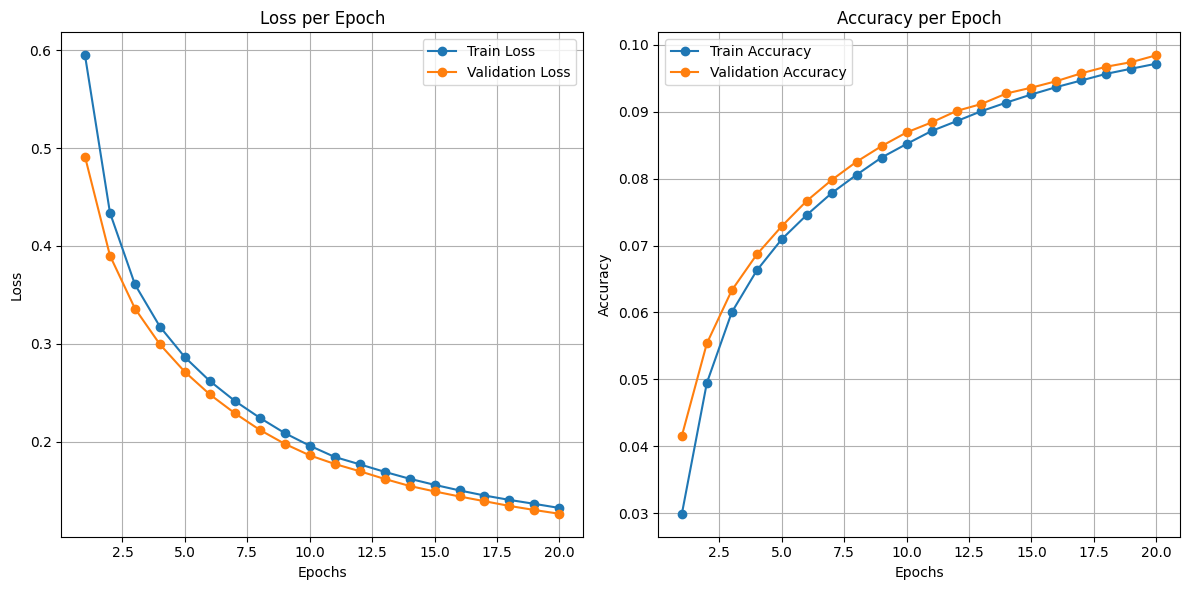

In [41]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Restore the latest checkpoint if it exists
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f"Restored from {latest_checkpoint}")
else:
    print("Starting training from scratch.")


# Lists to store metrics
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0

    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # Training loop
    for (batch, (inp, targ)) in enumerate(tqdm(train_dataset.take(train_steps_per_epoch), desc="Training", leave=False)):
        train_batch_loss, train_batch_accuracy = train_step_with_accuracy(inp, targ, enc_hidden)
        train_loss += train_batch_loss
        train_accuracy += train_batch_accuracy

    # Validation loop
    for (batch, (val_inp, val_tar)) in enumerate(tqdm(val_dataset.take(val_steps_per_epoch), desc="Validation", leave=False)):
        val_batch_loss, val_batch_accuracy = train_step_with_accuracy(val_inp, val_tar, enc_hidden)
        val_loss += val_batch_loss
        val_accuracy += val_batch_accuracy

    # Save metrics for this epoch
    train_loss /= train_steps_per_epoch
    train_accuracy /= train_steps_per_epoch
    val_loss /= val_steps_per_epoch
    val_accuracy /= val_steps_per_epoch

    train_loss_history.append(train_loss.numpy())
    train_accuracy_history.append(train_accuracy.numpy())
    val_loss_history.append(val_loss.numpy())
    val_accuracy_history.append(val_accuracy.numpy())

    # Save checkpoint
    if (epoch + 1) % 1 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    # Print metrics
    print(f"Epoch {epoch + 1} Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch + 1} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

plot_training_metrics(
    EPOCHS=EPOCHS,
    train_loss_history=train_loss_history,
    val_loss_history=val_loss_history,
    train_accuracy_history=train_accuracy_history,
    val_accuracy_history=val_accuracy_history
)



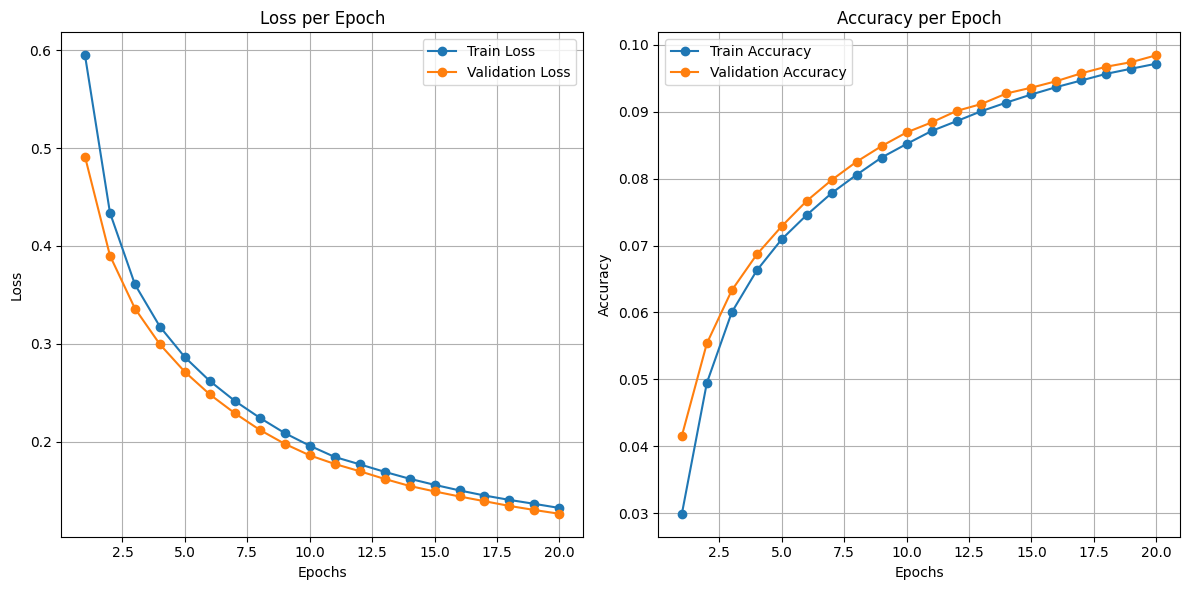

In [42]:
plot_training_metrics(
    EPOCHS=EPOCHS,
    train_loss_history=train_loss_history,
    val_loss_history=val_loss_history,
    train_accuracy_history=train_accuracy_history,
    val_accuracy_history=val_accuracy_history
)


# Load trained model

In [43]:
checkpoint.restore(f"{checkpoint_dir}/ckpt-{EPOCHS}")

In [44]:
# into base model
encoder = checkpoint.encoder
decoder = checkpoint.decoder

# Evaluation

Check bleu score

In [45]:
def predict(sentence):
    inputs = tf.convert_to_tensor(sentence)
    result = ''
    inputs = tf.expand_dims(inputs, axis=0)
    hidden = [tf.zeros((1, units)), tf.zeros((1, units))]
    enc_out, state = encoder(inputs, hidden)
    hidden_state = state
    dec_input = tf.expand_dims([target_lang_tokenize.word_index['start_']], 0)
    for t in range(max_length_target):
        predictions, hidden_state = decoder(dec_input,
                                                             hidden_state,
                                                             enc_out)

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_lang_tokenize.index_word[predicted_id] + ' '
        if target_lang_tokenize.index_word[predicted_id] == '_end' or len(result) > max_length_target:
            return result

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result

In [46]:
def create_reference(lang, tensor):
    all_sentence_list = []

    for word_list in tensor:
      sentence_list = []

      for t in word_list:
          if not t == 0:
              # Index number assigned to each word
              sentence_list.append(lang.index_word[t])
      all_sentence_list.append(sentence_list)
    return all_sentence_list

In [47]:

limit=60
# create reference
reference = create_reference(target_lang_tokenize, Y_test.tolist()[:limit])

In [48]:
from tqdm import tqdm
# create hypothesis
hypothesis = []
for i in tqdm(X_test[:limit]):
  hypothesis.append(predict(i))

100%|██████████| 60/60 [00:11<00:00,  5.37it/s]


In [49]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

score = 0
smoothie = SmoothingFunction().method2
for i in range(len(reference)):
    score += sentence_bleu([reference[i][1:-1]], hypothesis[i][:-5].strip().split(), smoothing_function=smoothie)

score /= len(reference)
print("The bleu score is: "+str(score))

The bleu score is: 0.3143833820365457


In [50]:
# for hyp,ref in zip(hypothesis,reference):
#   print("hypothesis: ",hyp)
#   print("reference: "," ".join(ref[1:-1]))

# Process references to join them excluding <sos> and <eos>
processed_references = [" ".join(ref[1:-1]) for ref in reference]
processed_hypothesis = [re.sub(r"_end", "", hyp).strip() for hyp in hypothesis]

# Create DataFrame
df = pd.DataFrame({
    "Hypothesis": processed_hypothesis,
    "Reference": processed_references
})

# Display the DataFrame
df

,Hypothesis,Reference
0,i want to see what to see what to see what to ...,i want to watch what is on tv right now
1,have you finished your trip,have you finished your preparations for the trip
2,i found it difficult to walk to walk to walk t...,i found it difficult to walk in the deep snow
3,are you going to college,do you go to college
4,i did not need a new smartphone,tom did not need a new coat
5,you have to give up smoking,i applaud your decision to quit smoking
6,why is my french,why is your french so good
7,i will is stolen the stolen the stolen the sto...,i will not give up on the stolen money
8,i do not like to play with work with work with...,i do not like to mix business with pleasure
9,cool,take it easy


In [51]:
import pandas as pd


# Create a DataFrame
history_df = pd.DataFrame({
    "Train Loss": train_loss_history,
    "Train Accuracy": train_accuracy_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_accuracy_history
})

# Save to CSV
history_df.to_csv(f"{checkpoint_dir}/training_history.csv", index=False)

print("Training history saved to 'training_history.csv'.")


Training history saved to 'training_history.csv'.


In [52]:
# Save encoder and decoder in Keras format
encoder.save('/kaggle/working/encoder_model.keras')
decoder.save('/kaggle/working/decoder_model.keras')
import json

# Save the input tokenizer
with open('/kaggle/working/input_tokenizer.json', 'w') as f:
    f.write(json.dumps(input_lang_tokenize.to_json()))

# Save the target tokenizer
with open('/kaggle/working/target_tokenizer.json', 'w') as f:
    f.write(json.dumps(target_lang_tokenize.to_json()))


In [53]:
from tensorflow.keras.models import load_model

# Load the encoder model
encoder = load_model('/kaggle/working/encoder_model.keras')

# Load the decoder model
decoder = tf.keras.models.load_model('/kaggle/working/decoder_model.keras', custom_objects={'Decoder': Decoder})


/opt/conda/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'encoder' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/opt/conda/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'decoder' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state

In [54]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# Load the input tokenizer
with open('/kaggle/working/input_tokenizer.json', 'r') as f:
    input_lang_tokenize = tokenizer_from_json(json.load(f))

# Load the target tokenizer
with open('/kaggle/working/target_tokenizer.json', 'r') as f:
    target_lang_tokenize = tokenizer_from_json(json.load(f))


In [55]:
def predict_sequence(input_text, encoder, decoder, input_tokenizer, target_tokenizer, max_target_length):
    # Preprocess the input
    preprocessed_input = preprocess_japanese_text(input_text)  # Adjust for your input language
    input_sequence = input_tokenizer.texts_to_sequences([preprocessed_input])
    input_sequence = tf.keras.preprocessing.sequence.pad_sequences(input_sequence, maxlen=max_length_input, padding='post')

    # Encode the input
    # Change here to set batch size to 1
    initial_hidden = encoder.initialize_hidden_state()
    initial_hidden = [tf.zeros((1, encoder.enc_units)), tf.zeros((1, encoder.enc_units))]  # Adjust shape to (1, units)
    
    enc_output, enc_hidden = encoder(input_sequence, initial_hidden)

    # Prepare the decoder's initial input and states
    decoder_input = tf.expand_dims([target_tokenizer.word_index['start_']], 0)  # Start token

    # Correct here to use the state returned by the encoder with proper batch dimension
    dec_hidden = enc_hidden
    
    result = []

    for _ in range(max_target_length):
        # Predict the next word
        predictions, dec_hidden = decoder(decoder_input, dec_hidden, enc_output)

        # Get the token with the highest probability
        predicted_token = tf.argmax(predictions[0]).numpy()
        result.append(predicted_token)

        # Stop if end token is predicted
        if target_tokenizer.index_word[predicted_token] == '_end':
            break

        # Use the predicted token as the next input
        decoder_input = tf.expand_dims([predicted_token], 0)

    # Convert the tokens back to text
    result_text = ' '.join([target_tokenizer.index_word[token] for token in result if token in target_tokenizer.index_word])
    return result_text


custom_input = "彼は犬を飼っています"
predicted_output = predict_sequence(
    custom_input,
    encoder,
    decoder,
    input_lang_tokenize,
    target_lang_tokenize,
    max_length_target
)
print(f"Input: {custom_input}")
print(f"Translation: {predicted_output}")


Input: 彼は犬を飼っています
Translation: meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling privacy meddling


In [56]:
# def predict(input_text, encoder, decoder, input_lang_tokenizer, target_lang_tokenizer, max_length_input, max_length_target):
#     input_seq = input_lang_tokenizer.texts_to_sequences([input_text])
#     input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=max_length_input, padding='post')

#     # Ensure the input sequence has batch size 1
#     input_seq = tf.expand_dims(input_seq[0], axis=0)  # Shape becomes (1, max_length_input)

#     # Create initial hidden state (replace with appropriate dimensions and type)
#     # Assuming your encoder uses LSTM, you might need to create two hidden states (h and c)
#     hidden_state = tf.zeros((1, encoder.units))  # Replace encoder.units with the actual number of units in your encoder
#     cell_state = tf.zeros((1, encoder.units))  # Replace encoder.units with the actual number of units in your encoder

#     # Pass through the encoder, providing the hidden state
#     enc_output, enc_hidden = encoder(input_seq, hidden_state=hidden_state, cell_state=cell_state)

#     # Set up decoder input and initial hidden state
#     dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']], 0)  # Shape: (1, 1)
#     dec_hidden = enc_hidden

#     translation = []
#     for t in range(max_length_target):
#         # Pass through the decoder
#         dec_output, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

#         # Get the token with the highest probability
#         predicted_id = tf.argmax(dec_output[0]).numpy()

#         # Stop if the end token is predicted
#         if target_lang_tokenizer.index_word[predicted_id] == '<end>':
#             break

#         # Append the predicted word to the translation
#         translation.append(target_lang_tokenizer.index_word[predicted_id])

#         # Update the decoder input to the predicted token
#         dec_input = tf.expand_dims([predicted_id], 0)

#     return ' '.join(translation)


In [57]:
# # Example input text
# user_input = "こんにちは"

# # Call the predict function
# translation = predict(
#     input_text=user_input,
#     encoder=encoder,
#     decoder=decoder,
#     input_lang_tokenizer=input_lang_tokenize,
#     target_lang_tokenizer=target_lang_tokenize,
#     max_length_input=max_length_input,
#     max_length_target=max_length_target
# )

# print(f"Input: {user_input}")
# print(f"Translation: {translation}")


In [58]:
# text="私は犬を飼っています"
# text=remove_emojis(text)
# text=zen_to_han(text)
# text=preprocess_japanese_text(text)
# input_tensor_try, input_lang_tokenize_try = tokenize(text)
# input_tensor_try

In [59]:
# predict(input_tensor_try)

# Translation example

In [60]:
# def preprocess_sentence(en_text):
#     # normalize Japanese
#     ja_text = japanese_unicode_to_ascii(en_text)
#     ja_text = preprocess_japanese_text(ja_text)
#     ja_text = zen_to_han(ja_text)

#     # add StTART and END sentence
#     # ja_text = "start_ " + ja_text + " _end"
#     return ja_text

# def evaluate(sentence):

#     attention_plot = np.zeros((max_length_target, max_length_input))
#     sentence = preprocess_sentence(sentence).strip()  # Remove extra spaces at start/end
#     inputs = [input_lang_tokenize.word_index[i] for i in sentence.split(' ') if i in input_lang_tokenize.word_index]

#     inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
#                                                            maxlen=max_length_input,
#                                                            padding='post')

#     inputs = tf.convert_to_tensor(inputs)
#     result = ''
#     hidden = [tf.zeros((1, units)), tf.zeros((1, units))]
#     enc_out, state = encoder(inputs, hidden)
#     hidden_state = state
#     dec_input = tf.expand_dims([target_lang_tokenize.word_index['start_']], 0)
#     for t in range(max_length_target):
#         predictions, hidden_state = decoder(dec_input, hidden_state, enc_out)
#         predicted_id = tf.argmax(predictions[0]).numpy()

#         result += target_lang_tokenize.index_word[predicted_id] + ' '
#         if target_lang_tokenize.index_word[predicted_id] == '_end' or len(result) > max_length_target:
#             return result, sentence

#         # the predicted ID is fed back into the model
#         dec_input = tf.expand_dims([predicted_id], 0)
#     return result, sentence,

In [61]:
# from nltk.translate.bleu_score import sentence_bleu

# def result(sentence):
#     result, sentence = evaluate(sentence)

#     return result, sentence

In [62]:
# # result, sentence = result("he has a dog")
# result, sentence = result("彼は犬を飼っています")
# print('Input: %s' % (sentence))
# print('Predicted translation: {}'.format(result))

In [63]:
# # result, sentence = result("What is this!?")
# result, sentence = result("これは何ですか!?")
# print('Input: %s' % (sentence))
# print('Predicted translation: {}'.format(result))

In [64]:
# # result, sentence = result("Actually I did it")
# result, sentence = result("実は、私がやりました。")
# print('Input: %s' % (sentence))
# print('Predicted translation: {}'.format(result))

In [65]:
# result, sentence = result("I love her")
# print('Input: %s' % (sentence))
# print('Predicted translation: {}'.format(result))